In [1]:
%matplotlib inline
import sys
from os.path import exists

# this is the repository I pulled/downloaded from github: 
CONGA_PATH = '/rd2/user/xiacr/sle/source/conga/'
# confirm that it's the right level directory (since the repo and library have the same name)
assert exists(CONGA_PATH+'/README.md')
sys.path.append(CONGA_PATH)

import scanpy as sc
import conga
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# subset the B cell and plasma only

In [2]:
adata = sc.read_h5ad('./step2/all_bcell_merged_gex.h5ad')

In [3]:
adata.obs['old_index'] = adata.obs.index
adata.obs

,batch_gex_data,batch_clones_file,batch,old_index
AAACCTGAGAAGGTGA-1-0,/rd2/user/xiacr/sle/data/10x_rna/GW_rna.h5,/rd2/user/xiacr/sle/scripts/conga/BCR/all/step...,0,AAACCTGAGAAGGTGA-1-0
AAACCTGAGCTAGTGG-1-0,/rd2/user/xiacr/sle/data/10x_rna/GW_rna.h5,/rd2/user/xiacr/sle/scripts/conga/BCR/all/step...,0,AAACCTGAGCTAGTGG-1-0
AAACCTGAGCTCCTTC-1-0,/rd2/user/xiacr/sle/data/10x_rna/GW_rna.h5,/rd2/user/xiacr/sle/scripts/conga/BCR/all/step...,0,AAACCTGAGCTCCTTC-1-0
AAACCTGAGCTGCGAA-1-0,/rd2/user/xiacr/sle/data/10x_rna/GW_rna.h5,/rd2/user/xiacr/sle/scripts/conga/BCR/all/step...,0,AAACCTGAGCTGCGAA-1-0
AAACCTGAGCTTCGCG-1-0,/rd2/user/xiacr/sle/data/10x_rna/GW_rna.h5,/rd2/user/xiacr/sle/scripts/conga/BCR/all/step...,0,AAACCTGAGCTTCGCG-1-0
...,...,...,...,...
TTTGTCATCGCGCCAA-1-21,/rd2/user/xiacr/sle/data/10x_rna/ZS_rna.h5,/rd2/user/xiacr/sle/scripts/conga/BCR/all/step...,21,TTTGTCATCGCGCCAA-1-21
TTTGTCATCGGCGCAT-1-21,/rd2/user/xiacr/sle/data/10x_rna/ZS_rna.h5,/rd2/user/xiacr/sle/scripts/conga/BCR/all/step...,21,TTTGTCATCGGCGCAT-1-21
TTTGTCATCTCTGCTG-1-21,/rd2/user/xiacr/sle/data/10x_rna/ZS_rna.h5,/rd2/user/xiacr/sle/scripts/conga/BCR/all/step...,21,TTTGTCATCTCTGCTG-1-21
TTTGTCATCTGACCTC-1-21,/rd2/user/xiacr/sle/data/10x_rna/ZS_rna.h5,/rd2/user/xiacr/sle/scripts/conga/BCR/all/step...,21,TTTGTCATCTGACCTC-1-21


In [4]:
# seu_meta.iloc[:,0]
tmp = adata.obs.batch_gex_data.str.split('/',expand=True).iloc[:,7].str.split('_',expand=True).iloc[:,0].reset_index(drop=True) # sample name
adata.obs['seu_barcode'] = 'unknown'
adata.obs['seu_barcode'] = ( tmp + '_' +adata.obs.index.str.split('1-',expand=True,n=1).to_frame().iloc[:,0].reset_index(drop=True)  + '1').to_list()

In [5]:
b_seu_meta = pd.read_csv('./seurat_bcell_filter_meta.csv')
b_seu_meta.iloc[:,0] = b_seu_meta.iloc[:,0].str.replace('_SLE|_HC','',regex=True)
plasma_seu_meta = pd.read_csv('./seurat_plasma_filter_meta.csv')
plasma_seu_meta.iloc[:,0] = plasma_seu_meta.iloc[:,0].str.replace('_SLE|_HC','',regex=True)
seu_meta = pd.concat([b_seu_meta,plasma_seu_meta], join = 'inner')

In [6]:
seu_meta.iloc[:,0].isin(adata.obs['seu_barcode']).value_counts()

True    26037
Name: Unnamed: 0, dtype: int64

In [7]:
adata.obs['seu_barcode'].isin(seu_meta.iloc[:,0]).value_counts()

False    227929
True      26037
Name: seu_barcode, dtype: int64

In [8]:
tmp = adata.obs.merge(right= seu_meta, left_on='seu_barcode',right_on='Unnamed: 0',how  = 'left')
tmp.index = tmp['seu_barcode']
adata.obs = tmp

In [9]:
adata.obs.treatment.isna().value_counts()
adata = adata[~adata.obs.treatment.isna()]

In [10]:
adata.obs.index = adata.obs.old_index
adata.obs.index.name  = 'cell_barcode'
adata.write_h5ad('./step2/all_bcell_merged_gex_subset.h5ad')

/home/xiacr/miniconda3/envs/conga/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
/home/xiacr/miniconda3/envs/conga/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'orig.ident' as categorical
/home/xiacr/miniconda3/envs/conga/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
Trying to set attribute `.obs

In [11]:
adata.obs

,batch_gex_data,batch_clones_file,batch,old_index,seu_barcode,Unnamed: 0,orig.ident,nCount_RNA,nFeature_RNA,group,...,G2M.Score,Phase,old.ident,RNA_snn_res.0.8,RNA_snn_res.1,seurat_clusters,main_type,PIC,RNA_snn_res.0.6,subtype
cell_barcode,,,,,,,,,,,,,,,,,,,,,
AAACCTGCACCGCTAG-1-0,/rd2/user/xiacr/sle/data/10x_rna/GW_rna.h5,/rd2/user/xiacr/sle/scripts/conga/BCR/all/step...,0,AAACCTGCACCGCTAG-1-0,GW_AAACCTGCACCGCTAG-1,GW_AAACCTGCACCGCTAG-1,GW,3424.0,1471.0,SLE,...,-0.011282,S,4.0,6.0,7.0,6.0,Bcell,no,3.0,B.mem.IGHM+
AAACCTGCACTAAGTC-1-0,/rd2/user/xiacr/sle/data/10x_rna/GW_rna.h5,/rd2/user/xiacr/sle/scripts/conga/BCR/all/step...,0,AAACCTGCACTAAGTC-1-0,GW_AAACCTGCACTAAGTC-1,GW_AAACCTGCACTAAGTC-1,GW,3141.0,1494.0,SLE,...,0.125939,G2M,1.0,2.0,3.0,2.0,Bcell,no,0.0,B.transition
AAACCTGGTCTCTTAT-1-0,/rd2/user/xiacr/sle/data/10x_rna/GW_rna.h5,/rd2/user/xiacr/sle/scripts/conga/BCR/all/step...,0,AAACCTGGTCTCTTAT-1-0,GW_AAACCTGGTCTCTTAT-1,GW_AAACCTGGTCTCTTAT-1,GW,5943.0,2090.0,SLE,...,0.008381,G2M,4.0,6.0,7.0,6.0,Bcell,no,3.0,B.mem.IGHM+
AAACGGGCACAGATTC-1-0,/rd2/user/xiacr/sle/data/10x_rna/GW_rna.h5,/rd2/user/xiacr/sle/scripts/conga/BCR/all/step...,0,AAACGGGCACAGATTC-1-0,GW_AAACGGGCACAGATTC-1,GW_AAACGGGCACAGATTC-1,GW,4084.0,1440.0,SLE,...,-0.032178,S,1.0,1.0,3.0,1.0,Bcell,no,0.0,B.naive
AAACGGGGTTTGTTTC-1-0,/rd2/user/xiacr/sle/data/10x_rna/GW_rna.h5,/rd2/user/xiacr/sle/scripts/conga/BCR/all/step...,0,AAACGGGGTTTGTTTC-1-0,GW_AAACGGGGTTTGTTTC-1,GW_AAACGGGGTTTGTTTC-1,GW,4269.0,1767.0,SLE,...,-0.011835,G1,3.0,8.0,4.0,8.0,Bcell,no,5.0,B.mem
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTTCAAAGACA-1-21,/rd2/user/xiacr/sle/data/10x_rna/ZS_rna.h5,/rd2/user/xiacr/sle/scripts/conga/BCR/all/step...,21,TTTGGTTTCAAAGACA-1-21,ZS_TTTGGTTTCAAAGACA-1,ZS_TTTGGTTTCAAAGACA-1,ZS,2890.0,1268.0,HC,...,-0.053220,S,0.0,0.0,0.0,0.0,Bcell,no,0.0,B.naive
TTTGGTTTCACCAGGC-1-21,/rd2/user/xiacr/sle/data/10x_rna/ZS_rna.h5,/rd2/user/xiacr/sle/scripts/conga/BCR/all/step...,21,TTTGGTTTCACCAGGC-1-21,ZS_TTTGGTTTCACCAGGC-1,ZS_TTTGGTTTCACCAGGC-1,ZS,6446.0,1929.0,HC,...,-0.005806,G1,3.0,8.0,9.0,8.0,Bcell,no,3.0,B.mem
TTTGTCAAGAGCTGGT-1-21,/rd2/user/xiacr/sle/data/10x_rna/ZS_rna.h5,/rd2/user/xiacr/sle/scripts/conga/BCR/all/step...,21,TTTGTCAAGAGCTGGT-1-21,ZS_TTTGTCAAGAGCTGGT-1,ZS_TTTGTCAAGAGCTGGT-1,ZS,15133.0,2917.0,HC,...,-0.101538,G1,2.0,4.0,5.0,1.0,Plasma,no,7.0,plasma.IgA


# do conga analysis

In [12]:
gex_datafile = './step2/all_bcell_merged_gex_subset.h5ad'
gex_datatype = 'h5ad' # other possibilities right now: ['10x_mtx', 'h5ad'] (h5ad from scanpy)
# tcr_datafile = './step2/' # not need
organism = 'human_ig'

clones_file = './step2/all_bcell_merged_clones.tsv'
kpca_file = './step2/all_bcell_merged_clones_AB.dist_50_kpcs'
outfile_prefix = 'bcell_plasma_subset' # this string will be prepended to results (figure and table) filenames

assert exists(gex_datafile)
assert exists(clones_file)

In [13]:
adata = conga.preprocess.read_dataset(gex_datafile, gex_datatype, clones_file ,kpca_file = kpca_file)

reading: ./step2/all_bcell_merged_gex_subset.h5ad of type h5ad


/rd2/user/xiacr/sle/source/conga/conga/preprocess.py:226: DeprecationWarning: Use is_view instead of isview, isview will be removed in the future.
  if adata.isview: # ran into trouble with AnnData views vs copies


total barcodes: 26037 (26037, 36601)
reading: ./step2/all_bcell_merged_clones.tsv
reading: ./step2/all_bcell_merged_clones_AB.dist_50_kpcs
Reducing to the 23835 barcodes (out of 26037) with paired TCR sequence data


In [14]:
adata.uns['organism'] = organism

## filtering

In [15]:
# IF use para hvg_batch_key =  batch ?
adata = conga.preprocess.filter_and_scale( 
    adata, 
    min_genes_per_cell=200,
    max_genes_per_cell=10000,
    max_percent_mito=0.2,
    hvg_batch_key='batch'
)

filtered out 0 cells with more than 10000 genes
filtered out 0 cells with more than 0.2 percent mito
get_feature_types_varname: feature_types feature_type_counts: [('Gene Expression', 20273)]
num antibody features: 0


/home/xiacr/miniconda3/envs/conga/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'va' as categorical
/home/xiacr/miniconda3/envs/conga/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'ja' as categorical
/home/xiacr/miniconda3/envs/conga/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future ver

excluding 202 TR genes (140 variable)
excluding 2 sexlinked genes
total of 531 variable genes (23835, 20273)
Normalize and logging matrix...
get_feature_types_varname: feature_types feature_type_counts: [('Gene Expression', 531)]
feature_types counter: [('Gene Expression', 20273)]
normalize_and_log_the_raw_matrix: adata.raw.X.max()=  28415.0


In [16]:
adata = conga.preprocess.reduce_to_single_cell_per_clone(adata)

compute pca to find rep cell for each clone (23835, 531)
num_clones: 23205
normalize_and_log_the_raw_matrix:: matrix is already logged
choose representative cell for clone: 0 23205 (23835, 531)
choose representative cell for clone: 1000 23205 (23835, 531)
choose representative cell for clone: 2000 23205 (23835, 531)
choose representative cell for clone: 3000 23205 (23835, 531)
choose representative cell for clone: 4000 23205 (23835, 531)
choose representative cell for clone: 5000 23205 (23835, 531)
choose representative cell for clone: 6000 23205 (23835, 531)
choose representative cell for clone: 7000 23205 (23835, 531)
choose representative cell for clone: 8000 23205 (23835, 531)
choose representative cell for clone: 9000 23205 (23835, 531)
choose representative cell for clone: 10000 23205 (23835, 531)
choose representative cell for clone: 11000 23205 (23835, 531)
choose representative cell for clone: 12000 23205 (23835, 531)
choose representative cell for clone: 13000 23205 (23835, 5

In [17]:
adata = conga.preprocess.cluster_and_tsne_and_umap( adata, clustering_resolution = 0.8,clustering_method = 'leiden',n_gex_pcs=50)

computing X_pca_gex using sc.tl.pca
running 1D UMAP gex
ran leiden clustering: leiden_gex
running 1D UMAP tcr
ran leiden clustering: leiden_tcr


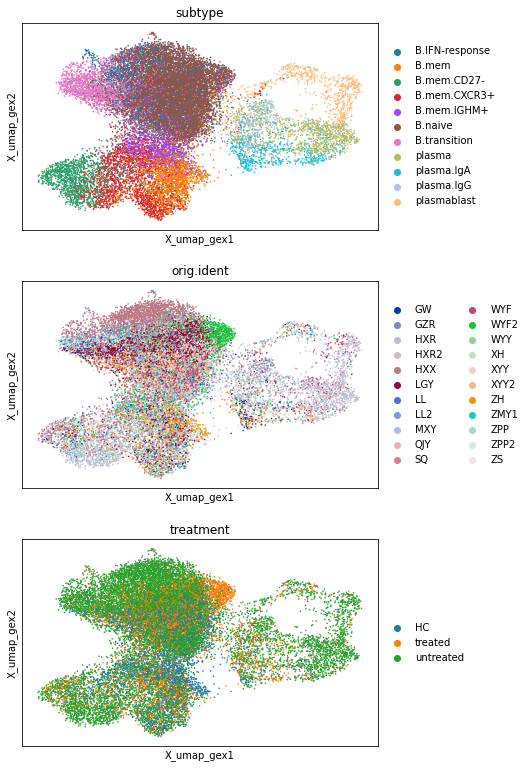

In [18]:
sc.pl.embedding(basis= 'X_umap_gex', adata = adata, color=[ 'subtype','orig.ident', 'treatment'],ncols=1,size=10 )

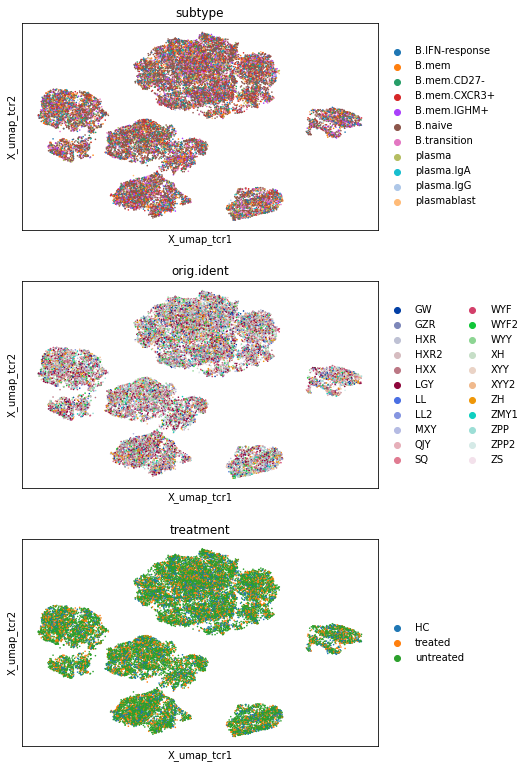

In [29]:
sc.pl.embedding(basis= 'X_umap_tcr', adata = adata, color=[ 'subtype','orig.ident', 'treatment'],ncols=1,size=10 )

In [19]:
nbr_fracs = [0.01, 0.1]

# we use this nbrhood size for computing the nndists
nbr_frac_for_nndists = 0.01

all_nbrs, nndists_gex, nndists_tcr = conga.preprocess.calc_nbrs(
    adata, nbr_fracs, also_calc_nndists=True, nbr_frac_for_nndists=nbr_frac_for_nndists)

# stash these in obs array, they are used in a few places...
adata.obs['nndists_gex'] = nndists_gex
adata.obs['nndists_tcr'] = nndists_tcr

conga.preprocess.setup_tcr_cluster_names(adata) #stores in adata.uns

allocating memory for 5383560 gex nbrs
allocated 21534240 bytes memory id= 140024809929296
allocating memory for 5383560 tcr nbrs
allocated 21534240 bytes memory id= 140024809942928
allocating memory for 53835600 gex nbrs
allocated 215342400 bytes memory id= 140024809930896
allocating memory for 53835600 tcr nbrs
allocated 215342400 bytes memory id= 140021371668976
compute D gex batch= 0 num_batches= 9 N= 23205 batch_size= 2892
argpartitions: gex batch= 0 nbr_frac= 0.01
argpartitions: gex batch= 0 nbr_frac= 0.1
compute D tcr batch= 0 num_batches= 9 N= 23205 batch_size= 2892
argpartitions: tcr batch= 0 nbr_frac= 0.01
argpartitions: tcr batch= 0 nbr_frac= 0.1
compute D gex batch= 1 num_batches= 9 N= 23205 batch_size= 2892
argpartitions: gex batch= 1 nbr_frac= 0.01
argpartitions: gex batch= 1 nbr_frac= 0.1
compute D tcr batch= 1 num_batches= 9 N= 23205 batch_size= 2892
argpartitions: tcr batch= 1 nbr_frac= 0.01
argpartitions: tcr batch= 1 nbr_frac= 0.1
compute D gex batch= 2 num_batches= 

In [20]:
results = conga.correlations.run_graph_vs_graph(
    adata, all_nbrs, outfile_prefix=outfile_prefix)


find_neighbor_neighbor_interactions:
find_neighbor_cluster_interactions:
find_neighbor_cluster_interactions:
find_neighbor_neighbor_interactions:
find_neighbor_cluster_interactions:
find_neighbor_cluster_interactions:
saved graph_vs_graph results to tsvfile: bcell_plasma_subset_graph_vs_graph.tsv


In [21]:
results = adata.uns['conga_results'][conga.tags.GRAPH_VS_GRAPH]
results.head() 

,conga_score,num_neighbors_gex,num_neighbors_tcr,overlap,overlap_corrected,mait_fraction,clone_index,nbr_frac,graph_overlap_type,cluster_size,gex_cluster,tcr_cluster,va,ja,cdr3a,vb,jb,cdr3b
1650,6.063169e-56,NaN,2320.0,744,723,0.0,6018,0.1,gex_cluster_vs_tcr_nbr,4228.0,1,2,IGKV2-24*01,IGKJ2*01,CTQGTHLPHTF,IGHV3-74*01,IGHJ4*01,CTRGPNNWRDVGDYW
604,2.294337e-49,2320.0,2320.0,470,463,0.0,5995,0.1,gex_nbr_vs_tcr_nbr,NaN,1,2,IGKV2-24*01,IGKJ2*01,CMQVTQFPHTF,IGHV3-7*01,IGHJ4*01,CARDDPSATKVDYW
677,5.915812e-49,2320.0,2320.0,469,462,0.0,6483,0.1,gex_nbr_vs_tcr_nbr,NaN,1,2,IGKV2-30*01,IGKJ1*01,CMQGTHWPWTF,IGHV3-11*01,IGHJ4*01,CATVLRGHNKDDGYW
1744,1.471290e-48,NaN,2320.0,721,703,0.0,6483,0.1,gex_cluster_vs_tcr_nbr,4228.0,1,2,IGKV2-30*01,IGKJ1*01,CMQGTHWPWTF,IGHV3-11*01,IGHJ4*01,CATVLRGHNKDDGYW
653,5.446137e-47,2320.0,2320.0,462,458,0.0,6382,0.1,gex_nbr_vs_tcr_nbr,NaN,1,2,IGKV2-30*01,IGKJ1*01,CMQGAHWPTF,IGHV3-7*01,IGHJ4*01,CARDPGYSSFDYW


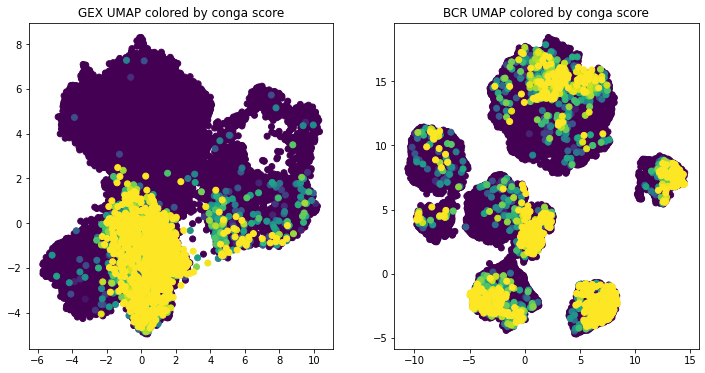

In [22]:
conga_scores = adata.obs['conga_scores']
colors = np.sqrt(np.maximum(-1*np.log10(conga_scores),0.0))
reorder = np.argsort(colors)

plt.figure(figsize=(12,6))
plt.subplot(121)
xy = adata.obsm['X_gex_2d']
plt.scatter( xy[reorder,0], xy[reorder,1], c=colors[reorder], vmin=0, vmax=np.sqrt(5))
plt.title('GEX UMAP colored by conga score')

plt.subplot(122)
xy = adata.obsm['X_tcr_2d']
plt.scatter( xy[reorder,0], xy[reorder,1], c=colors[reorder], vmin=0, vmax=np.sqrt(5))
plt.title('BCR UMAP colored by conga score');

In [28]:
adata.write_h5ad('./subset_result/bcell_plasma_subset.h5ad')
import pickle
with open('./subset_result/all_nbrs.pickle', 'wb') as f:
    pickle.dump(all_nbrs, f)

In [53]:
# tmp = adata.obs[adata.obs.conga_scores <1]
tmp = adata.obs[adata.obs.conga_scores <1 &  adata.obs.subtype.isin(['plasma','plasmablast','plasma.IgA','plasma.IgG'])]

In [51]:
adata.obs.subtype.value_counts()
adata.obs.subtype.isin(['plasma','plasmablast','plasma.IgA','plasma.IgG'])

cell_barcode
GTACGTAGTACAGTGG-1-8     False
CGTGTAATCCCACTTG-1-5     False
AGTGTCAAGGAACTGC-1-20     True
CTTTGCGGTAAGTAGT-1-17    False
CCTTACGTCCCTTGCA-1-10     True
                         ...  
GACTGCGAGGCGACAT-1-19    False
CCACGGACATAAGACA-1-18    False
ATGTGTGCAGATTGCT-1-13    False
CGTGAGCAGCGTGAGT-1-20    False
AGAGCTTCAAGCCGCT-1-10     True
Name: subtype, Length: 23205, dtype: bool

In [54]:
# tmp.treatment.value_counts()
tmp['orig.ident'].value_counts()

HXR     39
GW      22
ZPP     17
ZH      17
XYY2    17
HXR2    13
LGY     13
GZR     13
XH      12
SQ       8
XYY      7
ZPP2     6
ZS       6
WYF2     5
MXY      5
HXX      5
WYF      4
WYY      3
ZMY1     3
LL2      2
QJY      1
LL       0
Name: orig.ident, dtype: int64

In [44]:
tmp.to_csv('./cong_bcell_significant_adata_meta.csv')
adata.obs.to_csv('./cong_bcell_adata_meta.csv')

making tcr score table, #features= 35


/home/xiacr/miniconda3/envs/conga/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'test' as categorical


run rank_genes_groups [('none', 21395), ('clp_1_2', 297), ('clp_1_0', 254), ('clp_1_9', 196), ('clp_1_7', 156), ('clp_1_6', 137), ('clp_1_5', 118), ('clp_1_12', 70), ('clp_1_14', 65), ('clp_5_2', 48), ('clp_1_1', 44), ('clp_1_16', 43), ('clp_6_0', 39), ('clp_6_2', 29), ('clp_1_4', 28), ('clp_1_15', 28), ('clp_1_3', 28), ('clp_1_19', 26), ('clp_1_11', 23), ('clp_1_20', 22), ('clp_6_14', 20), ('clp_1_18', 18), ('clp_4_2', 18), ('clp_5_3', 13), ('clp_6_9', 12), ('clp_1_17', 11), ('clp_4_0', 11), ('clp_5_9', 10), ('clp_1_21', 9), ('clp_6_1', 8), ('clp_6_13', 6), ('clp_1_13', 6), ('clp_1_8', 6), ('clp_4_9', 6), ('clp_4_1', 5)]


/home/xiacr/miniconda3/envs/conga/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/home/xiacr/miniconda3/envs/conga/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/home/xiacr/miniconda3/envs/conga/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:399: PerformanceWa

making cluster logos: 0 34 bcell_plasma_subset_graph_vs_graph_logos.png
Error: conga.convert_svg_to_png failed to convert svg file to png file
Is the "convert" cmdline tool (ImageMagick) installed, or Inkscape?



Error: conga.convert_svg_to_png failed to convert svg file to png file
Is the "convert" cmdline tool (ImageMagick) installed, or Inkscape?


FileNotFoundError: [Errno 2] No such file or directory: 'bcell_plasma_subset_graph_vs_graph_logos.png.tmp_4_2_0.png'

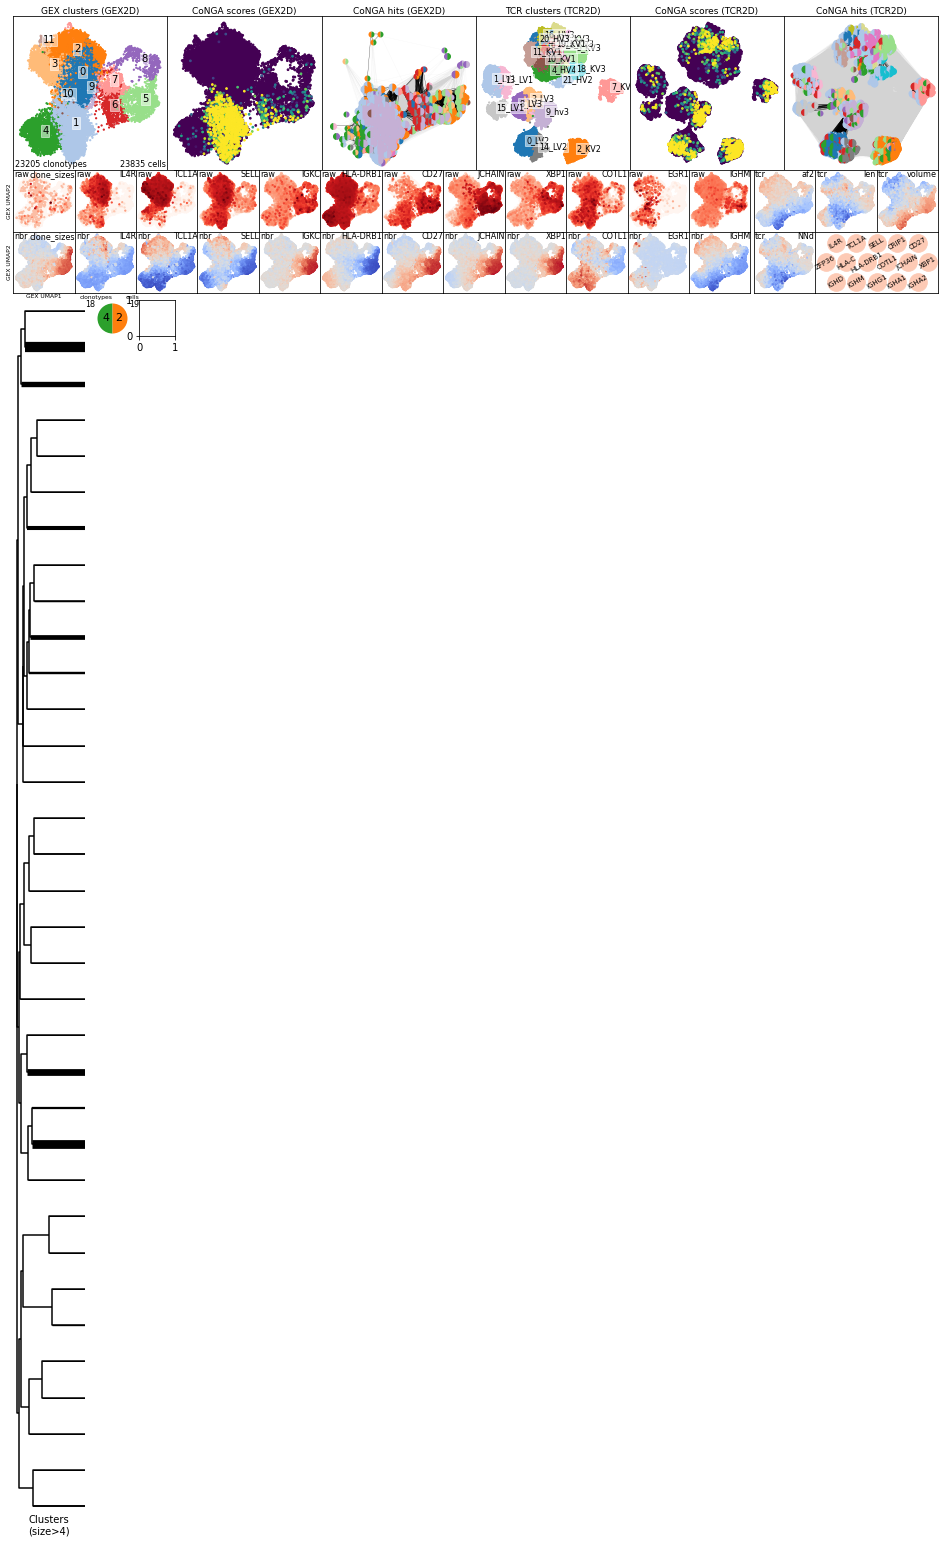

In [25]:
nbrs_gex, nbrs_tcr = all_nbrs[0.1]

min_cluster_size = 5

conga.plotting.make_graph_vs_graph_logos(
    adata,
    outfile_prefix,
    min_cluster_size,
    nbrs_gex,
    nbrs_tcr,
)